In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)

In [2]:
raw_data = pd.read_csv('data/train.csv')

C:\Users\Ethan\Anaconda3\envs\DS\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(np.unique(raw_data['PlayId'].values).size)
print(raw_data.columns)

23171
Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')


In [4]:
raw_data['Temperature'] = raw_data['Temperature'].fillna(raw_data['Temperature'].mean())
raw_data['Humidity'] = raw_data['Humidity'].fillna(raw_data['Humidity'].mean())

In [5]:
plays = np.unique(raw_data['PlayId'])
plays_trn, plays_val = train_test_split(plays, train_size=0.75)
data_trn = raw_data[raw_data['PlayId'].isin(plays_trn)]
data_val = raw_data[raw_data['PlayId'].isin(plays_val)]

In [6]:
def get_time(quarter, clock):
    split_time = clock.split(':')
    return (quarter-1)*15 + int(split_time[0]) + int(split_time[1])/60

def get_distance_to_touchdown(yard_line, possession_team, field_position):
    if possession_team != field_position:
        return yard_line
    else:
        return 100 - yard_line

def get_time_since_snap(time_handoff, time_snap):
    split_handoff = time_handoff.split(':')
    handoff_sec = int(split_handoff[1])*60 + int(split_handoff[2].split('.')[0])
    split_snap = time_handoff.split(':')
    snap_sec = int(split_snap[1])*60 + int(split_snap[2].split('.')[0])
    return float(handoff_sec) - float(snap_sec)

def get_height(player_height):
    split_height = player_height.split('-')
    return int(split_height[0])*12 + int(split_height[1])

def get_age(player_birth_date):
    return 2019 - int(player_birth_date.split('/')[2])

def encode_personnel(personnel):
    PERSONNELS = ['DB', 'DL', 'LB', 'OL', 'QB', 'RB', 'TE', 'WR']
    encoded_personnel = [0]*len(PERSONNELS)
    personnel = personnel.replace(' ','')
    for i in range(0,len(personnel),4):
        encoded_personnel[PERSONNELS.index(personnel[i+1:i+3])] += int(personnel[i])
    return encoded_personnel

def get_offense_features(formation, personnel):
    FORMATIONS = ['SHOTGUN','SINGLEBACK','JUMBO','PISTOL','I_FORM','ACE','WILDCAT','EMPTY']
    one_hot_formation = [int(f == formation) for f in FORMATIONS]
    return one_hot_formation + encode_personnel(personnel)

def get_defense_features(in_the_box, personnel):
    return [in_the_box] + encode_personnel(personnel)

def make_matrix(data_trn):
    BUFFER = 60
    offense_player_count = np.zeros((BUFFER*2+1,BUFFER*2+1))
    defense_player_count = np.zeros((BUFFER*2+1,BUFFER*2+1))
    offense_mean_yards = np.zeros((BUFFER*2+1,BUFFER*2+1))
    defense_mean_yards = np.zeros((BUFFER*2+1,BUFFER*2+1))
    for _,play in data_trn.groupby(['PlayId']):
        offense_team = play.loc[play['NflId'] == play['NflIdRusher'],'Team'].iloc[0]
        direction = play['PlayDirection'].iloc[0]
        yards = play['Yards'].iloc[0]
        ox = play.loc[play['NflId'] == play['NflIdRusher'],'X'].iloc[0]
        oy = play.loc[play['NflId'] == play['NflIdRusher'],'Y'].iloc[0]
        for _,player in play.iterrows():
            x = int(round(player['X']-ox+BUFFER)) if direction == 'right' else int(round(ox-player['X']+BUFFER))
            y = int(round(player['Y']-oy+BUFFER))
            if player['Team'] == offense_team:
                offense_player_count[y,x] += 1
                offense_mean_yards[y,x] = offense_mean_yards[y,x] + (yards - offense_mean_yards[y,x]) / offense_player_count[y,x]
            else:
                defense_player_count[y,x] += 1
                defense_mean_yards[y,x] = defense_mean_yards[y,x] + (yards - defense_mean_yards[y,x]) / defense_player_count[y,x]
    return offense_player_count,defense_player_count,offense_mean_yards,defense_mean_yards

def get_matrix_prediction(offense_player_count,defense_player_count,offense_mean_yards,defense_mean_yards,play):
    BUFFER = 60
    offense_team = play.loc[play['NflId'] == play['NflIdRusher'],'Team'].iloc[0]
    direction = play['PlayDirection'].iloc[0]
    yards = play['Yards'].iloc[0]
    ox = play.loc[play['NflId'] == play['NflIdRusher'],'X'].iloc[0]
    oy = play.loc[play['NflId'] == play['NflIdRusher'],'Y'].iloc[0]
    predictions = []
    weights = []
    for _,player in play.iterrows():
        x = int(round(player['X']-ox+BUFFER)) if direction == 'right' else int(round(ox-player['X']+BUFFER))
        y = int(round(player['Y']-oy+BUFFER))
        if player['Team'] == offense_team:
            predictions.append(offense_mean_yards[y,x])
            weights.append(offense_player_count[y,x])
        else:
            predictions.append(defense_mean_yards[y,x])
            weights.append(defense_player_count[y,x])
    return np.average(predictions, weights=weights)

In [ ]:
#opc,dpc,omy,dmy = make_matrix(data_trn)
input_trn = []
input_val = []
target_trn = []
target_val = []

In [9]:
for _,play in data_trn.groupby(['PlayId']):
    state_features = []
    state_features.append(get_distance_to_touchdown(play['YardLine'].iloc[0], play['PossessionTeam'].iloc[0], play['FieldPosition'].iloc[0]))
    state_features.append(get_time(play['Quarter'].iloc[0],play['GameClock'].iloc[0]))
    state_features.append(play['Down'].iloc[0])
    state_features.append(play['Distance'].iloc[0])
    state_features.append(get_time_since_snap(play['TimeHandoff'].iloc[0], play['TimeSnap'].iloc[0]))
    state_features.append(play['Temperature'].iloc[0])
    state_features.append(play['Humidity'].iloc[0])
    #state_features.append(get_matrix_prediction(opc,dpc,omy,dmy,play))
    offense_features = get_offense_features(play['OffenseFormation'].iloc[0], play['OffensePersonnel'].iloc[0])
    defense_features = get_defense_features(play['DefendersInTheBox'].iloc[0], play['DefensePersonnel'].iloc[0])
    for t,team in play.groupby(['Team']):
        team_features = []
        team_features.append(np.mean(team['X']))
        team_features.append(np.mean(team['Y']))
        team_features.append(np.mean(team['S']))
        team_features.append(np.mean(team['A']))
        team_features.append(np.mean(team['Dis']))
        team_features.append(np.mean(team['Orientation']))
        team_features.append(np.mean(team['Dir']))
        team_features.append(np.mean(team['PlayerHeight'].apply(lambda x: get_height(x))))
        team_features.append(np.mean(team['PlayerWeight']))
        team_features.append(np.mean(team['PlayerBirthDate'].apply(lambda x: get_age(x))))
        if t == 'home':
            team_features.append(team['HomeScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['HomeTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
        elif t == 'away':
            team_features.append(team['VisitorScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['VisitorTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
    if np.amax(np.isnan(state_features + offense_features + defense_features)) == 0:
        input_trn.append(state_features + offense_features + defense_features)
        target_trn.append(play['Yards'].iloc[0])

NameError: name 'opc' is not defined

In [10]:
for _,play in data_val.groupby(['PlayId']):
    state_features = []
    state_features.append(get_distance_to_touchdown(play['YardLine'].iloc[0], play['PossessionTeam'].iloc[0], play['FieldPosition'].iloc[0]))
    state_features.append(get_time(play['Quarter'].iloc[0],play['GameClock'].iloc[0]))
    state_features.append(play['Down'].iloc[0])
    state_features.append(play['Distance'].iloc[0])
    state_features.append(get_time_since_snap(play['TimeHandoff'].iloc[0], play['TimeSnap'].iloc[0]))
    state_features.append(play['Temperature'].iloc[0])
    state_features.append(play['Humidity'].iloc[0])
    #state_features.append(get_matrix_prediction(opc,dpc,omy,dmy,play))
    offense_features = get_offense_features(play['OffenseFormation'].iloc[0], play['OffensePersonnel'].iloc[0])
    defense_features = get_defense_features(play['DefendersInTheBox'].iloc[0], play['DefensePersonnel'].iloc[0])
    for t,team in play.groupby(['Team']):
        team_features = []
        team_features.append(np.mean(team['X']))
        team_features.append(np.mean(team['Y']))
        team_features.append(np.mean(team['S']))
        team_features.append(np.mean(team['A']))
        team_features.append(np.mean(team['Dis']))
        team_features.append(np.mean(team['Orientation']))
        team_features.append(np.mean(team['Dir']))
        team_features.append(np.mean(team['PlayerHeight'].apply(lambda x: get_height(x))))
        team_features.append(np.mean(team['PlayerWeight']))
        team_features.append(np.mean(team['PlayerBirthDate'].apply(lambda x: get_age(x))))
        if t == 'home':
            team_features.append(team['HomeScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['HomeTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
        elif t == 'away':
            team_features.append(team['VisitorScoreBeforePlay'].iloc[0])
            if team['PossessionTeam'].iloc[0] == team['VisitorTeamAbbr'].iloc[0]:
                offense_features = offense_features + team_features
            else:
                defense_features = defense_features + team_features
    if np.amax(np.isnan(state_features + offense_features + defense_features)) == 0:
        input_val.append(state_features + offense_features + defense_features)
        target_val.append(play['Yards'].iloc[0])

In [11]:
input_trn = np.stack(input_trn)
input_val = np.stack(input_val)
target_trn = np.stack(target_trn)
target_val = np.stack(target_val)

In [26]:
dtr = DecisionTreeRegressor(min_samples_leaf=128)
lr = LinearRegression()

dtr.fit(input_trn,target_trn)
error = dtr.predict(input_val) - target_val
squared_error = error * error
mse.append(np.mean(squared_error))
print(np.mean(squared_error))
lr.fit(input_trn,target_trn)
error = lr.predict(input_val) - target_val
squared_error = error * error
print(np.mean(squared_error))
print(np.mean((np.mean(target_trn)-target_val)*(np.mean(target_trn)-target_val)))

38.728027771597894
37.24141167567669
38.012019552805


In [33]:
lr.coef_

array([ 2.18128489e-02,  6.51208766e-04, -7.23140797e-03,  3.59831736e-02,
       -1.09134923e-12, -4.88825754e-03,  5.52208367e-04,  3.07241620e+00,
        3.20988855e+00,  3.00210512e+00,  3.24581332e+00,  2.95303492e+00,
        1.43598732e+00,  2.90353469e+00,  3.66787283e+00,  4.81944295e+00,
        5.89155813e-01,  1.39789342e+00,  2.28707121e-02,  6.63403270e-01,
        6.99885159e-01,  2.34921532e-01,  2.04198588e-01,  1.79233527e-03,
        6.86416616e-02,  7.17237845e-01,  8.42421457e-01,  2.91411120e+00,
        1.13953398e-04,  1.19767008e-03, -3.76218820e-02,  1.54882216e-02,
        1.17563517e-02,  1.18163006e-02, -3.22861874e-01,  2.35597736e-01,
        1.44711324e-01,  1.32308403e-03, -1.91258760e-03,  3.65825394e-01,
       -9.77667562e-02, -1.05509171e-02, -6.30872734e-03, -4.07294137e-03,
       -7.54836202e-02, -1.25464850e+00,  1.29165586e-01,  6.49597322e-01,
       -3.86730232e-04,  2.51446809e-03,  9.01986942e-02, -3.66753730e-02,
       -4.90731727e-02, -

In [30]:
input_ss = StandardScaler()
input_trn = input_ss.fit_transform(input_trn)
input_val = input_ss.transform(input_val)

model = Sequential()
model.add(Dense(units=16, activation='relu', input_shape=(input_trn.shape[1:])))
model.add(Dense(units=1,activation='softmax'))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=False)]

In [31]:
model.fit(x=input_trn, y=target_trn, epochs=1000, verbose=1, callbacks=callbacks, validation_data=(input_val,target_val))

Train on 17376 samples, validate on 5792 samples
Epoch 1/1000
17376/17376 [==============================] - 2s 122us/step - loss: 53.0404 - acc: 0.1188 - val_loss: 47.8771 - val_acc: 0.1188
Epoch 2/1000
17376/17376 [==============================] - 1s 73us/step - loss: 53.0404 - acc: 0.1188 - val_loss: 47.8771 - val_acc: 0.1188
Epoch 3/1000
17376/17376 [==============================] - 1s 75us/step - loss: 53.0404 - acc: 0.1188 - val_loss: 47.8771 - val_acc: 0.1188
Epoch 4/1000
17376/17376 [==============================] - 1s 74us/step - loss: 53.0404 - acc: 0.1188 - val_loss: 47.8771 - val_acc: 0.1188
Epoch 5/1000
17376/17376 [==============================] - 1s 75us/step - loss: 53.0404 - acc: 0.1188 - val_loss: 47.8771 - val_acc: 0.1188
Epoch 6/1000
17376/17376 [==============================] - 1s 75us/step - loss: 53.0404 - acc: 0.1188 - val_loss: 47.8771 - val_acc: 0.1188


In [32]:
prediction = model.predict(input_val)
print(np.mean((prediction-target_val)*(prediction-target_val)))

47.87707182320442


Text(0, 0.5, 'Predicted Yards')

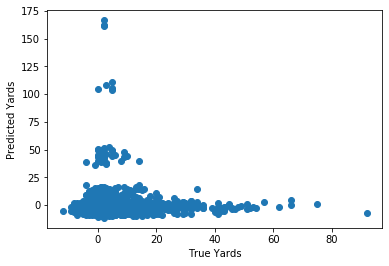

In [37]:
plt.scatter(target_val,lr.predict(input_val))
plt.xlabel('True Yards')
plt.ylabel('Predicted Yards')